This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model128 as model
import Loaddata as Loaddata
import TrainVaTe as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=0.001, help='initial learning rate [default: 0.001]')
parser.add_argument('-L2', type=float, default=0.00001, help='L2 regularization [default: 0.00001]')
parser.add_argument('-epochs', type=int, default=5, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr= np.exp(-8.8379)
args.L2= np.exp(-6.6844)
args.epochs = 25
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


In [6]:
print(len(train1), len(valid1), len(test1))

29912 4272 8545


In [7]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [8]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.7131419095109749
[1.4733099595745758, 1.315543282797715, 1.158607325537224, 1.150253750501138, 0.9651295572720267, 0.8461697256913099, 0.8070255172046563, 0.6858790163373354, 0.7458558803498856, 0.7858282926384899, 0.701065809498514, 0.7703128690878212, 0.5445132431028419, 0.5461991023288533, 0.6130989333973785, 0.528764353968984, 0.6304429251619408, 0.6603827431280413, 0.5998043929284522, 0.4261590363735144, 0.5297394392356207, 0.5719156749250869, 0.47024088283792753, 0.5605357047483662, 0.4914213593166445, 0.5564112639242716, 0.5667720228017079, 0.4491180119925637, 0.5306152991553889] 
 train loss plot


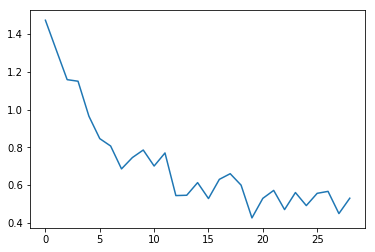


 Current running on: Epoch  0  Training auc: 0.7161525984695835


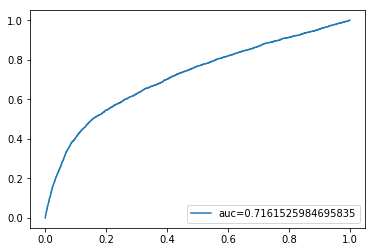


 Current running on: Epoch  0  validation auc: 0.6623540301635933


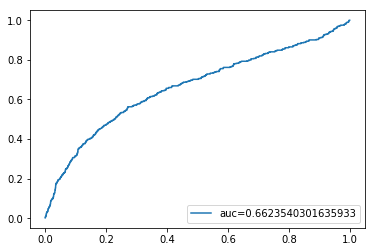


 Current running on: Epoch  0  test auc: 0.7099930870882746


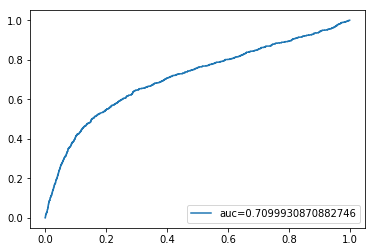

Epoch  0 Summary:  Training_auc : 0.7161525984695835  , Validation_auc :  0.6623540301635933  ,& Test_auc :  0.7099930870882746  Avg Loss:  0.7131419095109749 Train Time (0m 49s) Eval Time (0m 17s)

 Current running on: Epoch  1 Training loss:  Average loss 0.42326312591053694
[0.38899715341217506, 0.4445283529218316, 0.4184264473125421, 0.4022520566823752, 0.4172286715192878, 0.45111354753356186, 0.46253035537616916, 0.4429257722828824, 0.3945140974652032, 0.5303537572617532, 0.3647742401646529, 0.4272361202716166, 0.36188255733525054, 0.4608148929769364, 0.4265814318958059, 0.4568914804665363, 0.4334084009024521, 0.4230529298444203, 0.391488522339271, 0.447199224906543, 0.44203813727783836, 0.463789728346868, 0.4073335732692389, 0.34114375928601, 0.41058210611428475, 0.3873334367382591, 0.43422802724409326, 0.4145527166180686, 0.42742915363964484] 
 train loss plot


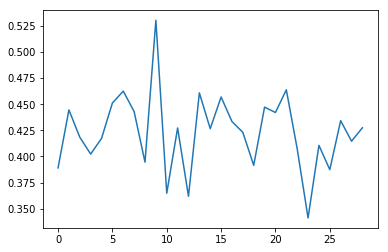


 Current running on: Epoch  1  Training auc: 0.6943968165574387


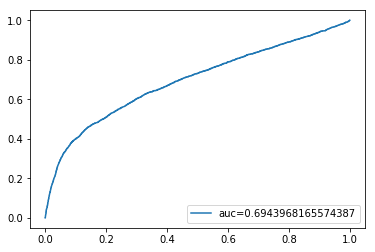


 Current running on: Epoch  1  validation auc: 0.6542765453227087


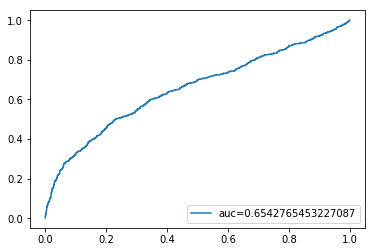


 Current running on: Epoch  1  test auc: 0.6979004546150485


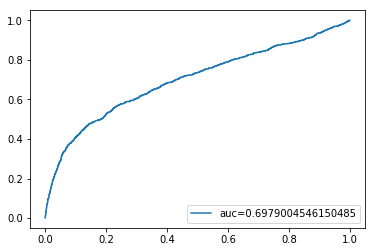

Epoch  1 Summary:  Training_auc : 0.6943968165574387  , Validation_auc :  0.6542765453227087  ,& Test_auc :  0.6979004546150485  Avg Loss:  0.42326312591053694 Train Time (0m 49s) Eval Time (0m 17s)

 Current running on: Epoch  2 Training loss:  Average loss 0.3893990794116858
[0.40367470134776196, 0.361496636002723, 0.3408015604255444, 0.4030333526622209, 0.3998986081409531, 0.3849632373279395, 0.4035775096573888, 0.3713533543710942, 0.4020902526512097, 0.37318304295995564, 0.40102010898432305, 0.4368559834297825, 0.3995219009569085, 0.3909448214178323, 0.39195751713541166, 0.35048789829749183, 0.4492777960434063, 0.36119173243441, 0.3625034929176446, 0.3548895624106368, 0.35597949011618735, 0.45714567847293053, 0.33880878869952313, 0.3615371325868424, 0.33397366769713405, 0.4786617600851996, 0.3860412650575399, 0.425574234533833, 0.41212821611506184] 
 train loss plot


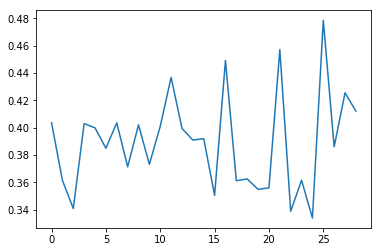


 Current running on: Epoch  2  Training auc: 0.7593984774279524


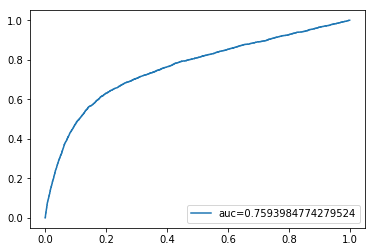


 Current running on: Epoch  2  validation auc: 0.7278662161962791


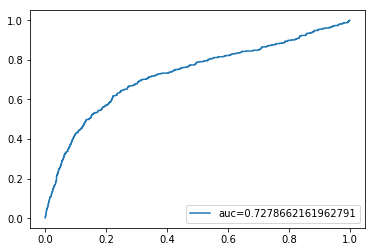


 Current running on: Epoch  2  test auc: 0.7685862007730387


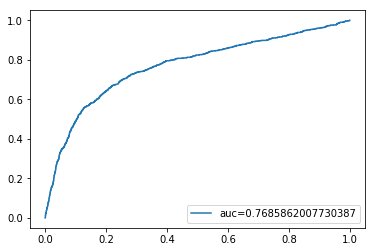

Epoch  2 Summary:  Training_auc : 0.7593984774279524  , Validation_auc :  0.7278662161962791  ,& Test_auc :  0.7685862007730387  Avg Loss:  0.3893990794116858 Train Time (0m 51s) Eval Time (0m 17s)

 Current running on: Epoch  3 Training loss:  Average loss 0.37619200043494816
[0.34701436863213914, 0.3804132913142877, 0.3865438311854542, 0.34530708735036186, 0.35676016756131324, 0.36194060941978806, 0.3357330284564836, 0.4065951481183643, 0.41144696061398556, 0.4736138964221281, 0.35912990994590915, 0.337863752352775, 0.40319561919164904, 0.42829511492910605, 0.33371758202080665, 0.32758285378319046, 0.4111192555281173, 0.3778950700789529, 0.3844824710500463, 0.3590610965991578, 0.4119023526431822, 0.3619292912995952, 0.40056436939140033, 0.3415433656939922, 0.347475630112762, 0.3685641967580786, 0.4226815014716023, 0.3376756886719503, 0.3895205020169185] 
 train loss plot


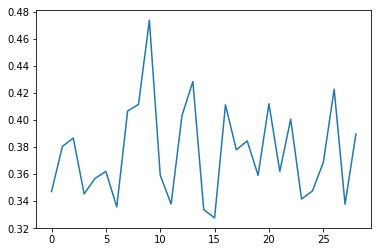


 Current running on: Epoch  3  Training auc: 0.753038840341497


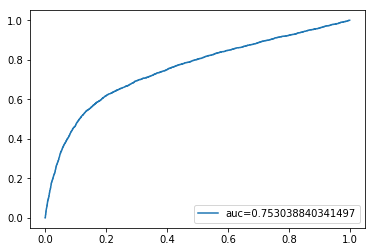


 Current running on: Epoch  3  validation auc: 0.7120964741020508


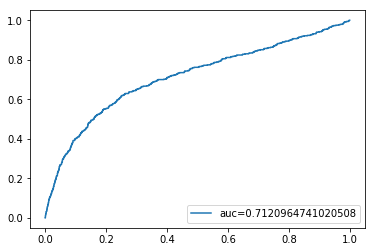


 Current running on: Epoch  3  test auc: 0.7578772384358979


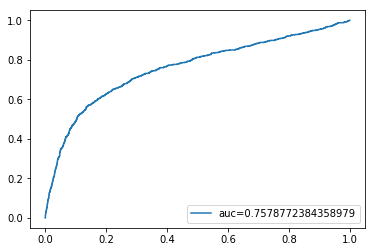

Epoch  3 Summary:  Training_auc : 0.753038840341497  , Validation_auc :  0.7120964741020508  ,& Test_auc :  0.7578772384358979  Avg Loss:  0.37619200043494816 Train Time (0m 48s) Eval Time (0m 17s)

 Current running on: Epoch  4 Training loss:  Average loss 0.37230054021154646
[0.38566026143655624, 0.4069819915570896, 0.3562461929725455, 0.37396988676217496, 0.4465486526155862, 0.3276879955163947, 0.36425389730436986, 0.3300172969736778, 0.4030940232211529, 0.4020659554342508, 0.37082250745358636, 0.3709362692018538, 0.37441209703087336, 0.369980621841941, 0.2868395111787387, 0.4157708358580578, 0.3890013832088047, 0.3409850429206971, 0.3808858787651993, 0.3791049811159572, 0.36326715605550486, 0.3829450355968338, 0.3648221668884524, 0.3789691242771426, 0.3816502136679788, 0.3827930089999134, 0.36109067712591625, 0.3678402397969322, 0.3380727613566655] 
 train loss plot


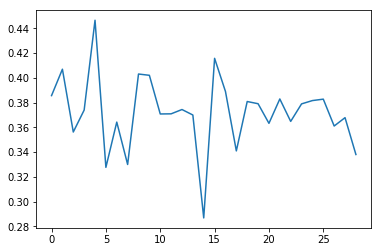


 Current running on: Epoch  4  Training auc: 0.7640703506167436


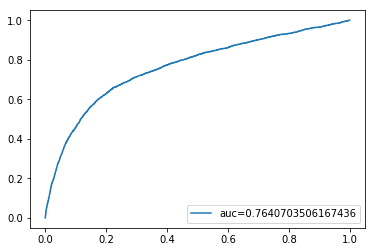


 Current running on: Epoch  4  validation auc: 0.7274006645585703


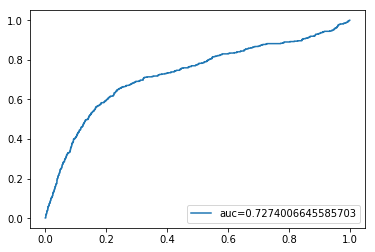


 Current running on: Epoch  4  test auc: 0.760054724045103


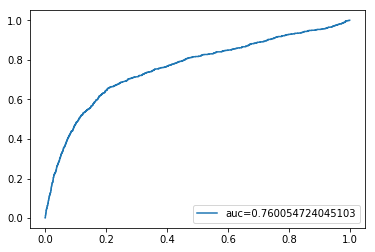

Epoch  4 Summary:  Training_auc : 0.7640703506167436  , Validation_auc :  0.7274006645585703  ,& Test_auc :  0.760054724045103  Avg Loss:  0.37230054021154646 Train Time (0m 55s) Eval Time (0m 19s)

 Current running on: Epoch  5 Training loss:  Average loss 0.36359422204278874
[0.4001159032265187, 0.37037191711990797, 0.35586324678753817, 0.36484106420534945, 0.3680378941277927, 0.35887921106107157, 0.395027928232019, 0.34327779815965453, 0.34100349903117094, 0.33801027326626326, 0.33020123660209655, 0.38401863109245826, 0.33543794450549885, 0.39147269458140066, 0.36918411328390566, 0.33736392069324506, 0.407309745093241, 0.3563917395251595, 0.37539048953847554, 0.42389276541696713, 0.3762672902688521, 0.3487027172384955, 0.34703578898412446, 0.36120022625664316, 0.37692536221854517, 0.34999572331047785, 0.30389208936400364, 0.3972124987088814, 0.3369087273411139] 
 train loss plot


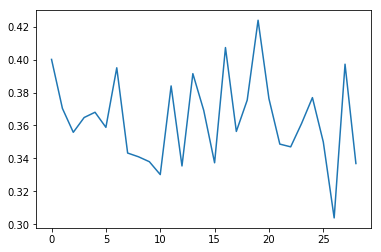


 Current running on: Epoch  5  Training auc: 0.7564656048078221


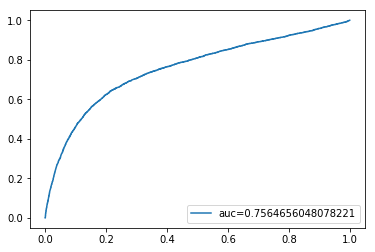


 Current running on: Epoch  5  validation auc: 0.7222298721317619


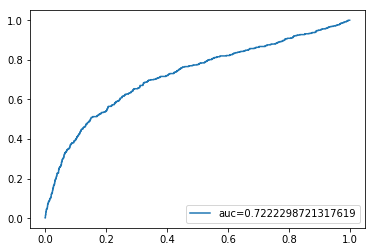


 Current running on: Epoch  5  test auc: 0.760187842467197


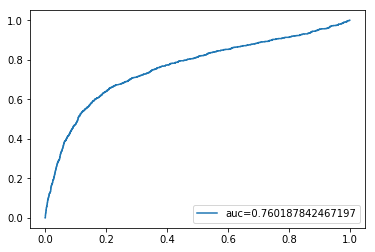

Epoch  5 Summary:  Training_auc : 0.7564656048078221  , Validation_auc :  0.7222298721317619  ,& Test_auc :  0.760187842467197  Avg Loss:  0.36359422204278874 Train Time (0m 50s) Eval Time (0m 17s)

 Current running on: Epoch  6 Training loss:  Average loss 0.3650492841375483
[0.3672127138127158, 0.4100334760623396, 0.35450249473435586, 0.3932492057433146, 0.32403056960078164, 0.39994018605709636, 0.3340501815878932, 0.3600110931907193, 0.39687945646829353, 0.35318723386225737, 0.3436200488970095, 0.3455423152991745, 0.3965528035173985, 0.41853835914472964, 0.3150856090219486, 0.3433312352854285, 0.3494544810874313, 0.3695622691635074, 0.36569799635499606, 0.37513697758420783, 0.3766467195496075, 0.3865041242472496, 0.36122674927020776, 0.3466861626802748, 0.326120323584264, 0.31996444630958776, 0.43541905427246136, 0.35466623499926, 0.36357671860038954] 
 train loss plot


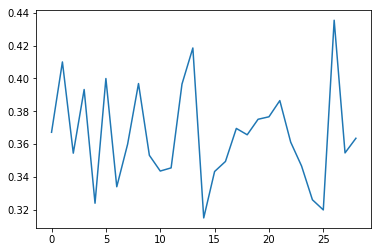


 Current running on: Epoch  6  Training auc: 0.7546290390330818


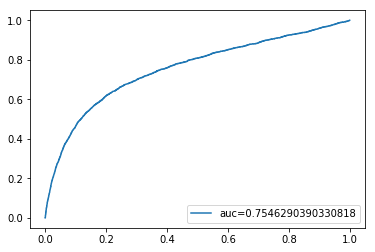


 Current running on: Epoch  6  validation auc: 0.7168525321473789


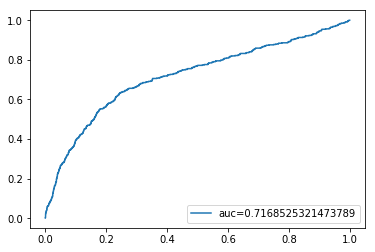


 Current running on: Epoch  6  test auc: 0.7568923796706005


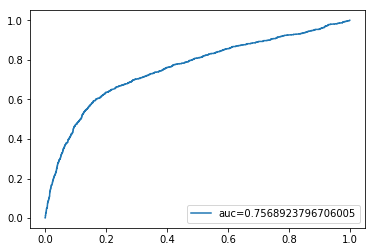

Epoch  6 Summary:  Training_auc : 0.7546290390330818  , Validation_auc :  0.7168525321473789  ,& Test_auc :  0.7568923796706005  Avg Loss:  0.3650492841375483 Train Time (0m 44s) Eval Time (0m 17s)

 Current running on: Epoch  7 Training loss:  Average loss 0.35833061767885926
[0.38391601245639, 0.3366014141279937, 0.31670666254392815, 0.3542581456450012, 0.36388068586226935, 0.3786756689990726, 0.36384325277836177, 0.3304894287003627, 0.3685403438994353, 0.35704965779585995, 0.33441287235943506, 0.37157751222207686, 0.35874501374799067, 0.33206654814310543, 0.34133705039177176, 0.3849941874128867, 0.3894531020007967, 0.3848871604833887, 0.38863094718995567, 0.375733013365798, 0.38207600135600045, 0.33534317246946466, 0.37412589110826594, 0.3854158615380419, 0.3678951352779971, 0.3407324058687603, 0.31676666158071065, 0.31495360912470105, 0.3584804942370967] 
 train loss plot


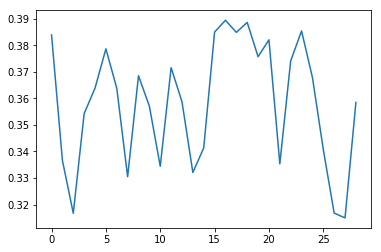


 Current running on: Epoch  7  Training auc: 0.7012560645354147


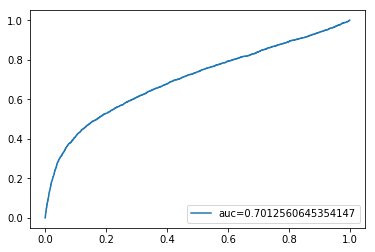


 Current running on: Epoch  7  validation auc: 0.6643069427846873


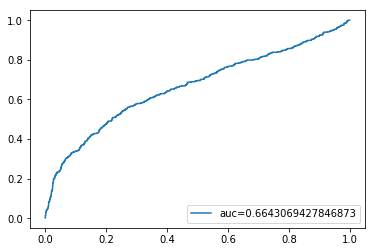


 Current running on: Epoch  7  test auc: 0.7084460443432556


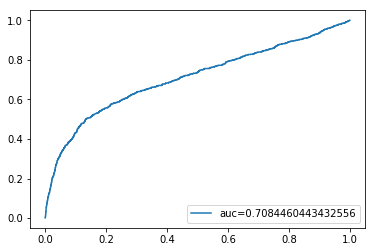

Epoch  7 Summary:  Training_auc : 0.7012560645354147  , Validation_auc :  0.6643069427846873  ,& Test_auc :  0.7084460443432556  Avg Loss:  0.35833061767885926 Train Time (0m 43s) Eval Time (0m 16s)

 Current running on: Epoch  8 Training loss:  Average loss 0.35362844790941134
[0.33313241894845214, 0.3493513550102846, 0.3272461692346327, 0.38968213233980714, 0.34170007966844945, 0.3710812936027114, 0.3591332994824842, 0.34379554402604423, 0.33959483952968217, 0.311266521689556, 0.31748807247958855, 0.4291945173470661, 0.3738291289692579, 0.33730756616018404, 0.3489205850427647, 0.3605827746237054, 0.3477001677430976, 0.3453835050963198, 0.3288057039134315, 0.3622595164366097, 0.37925747196074444, 0.38233878307032615, 0.3474219163998387, 0.3554322208318645, 0.3651398399045429, 0.30200826323023083, 0.36920617270059225, 0.3532512231716138, 0.3837139067590468] 
 train loss plot


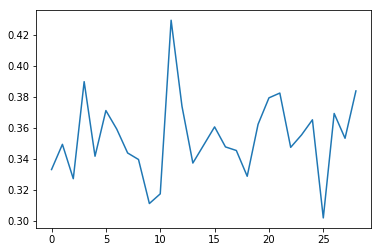


 Current running on: Epoch  8  Training auc: 0.7690368399986957


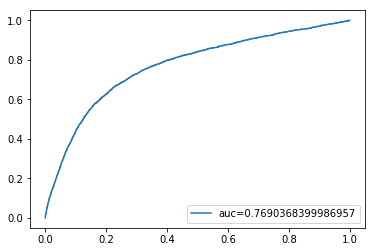


 Current running on: Epoch  8  validation auc: 0.7431078413212049


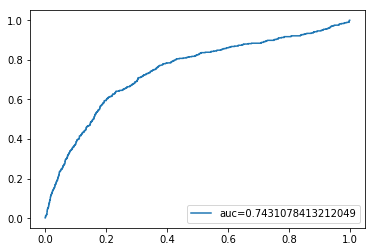


 Current running on: Epoch  8  test auc: 0.7634644728823223


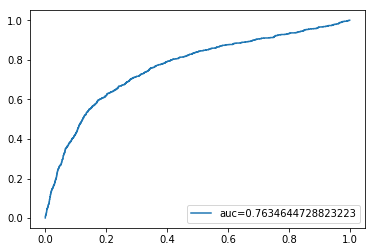

Epoch  8 Summary:  Training_auc : 0.7690368399986957  , Validation_auc :  0.7431078413212049  ,& Test_auc :  0.7634644728823223  Avg Loss:  0.35362844790941134 Train Time (0m 44s) Eval Time (0m 16s)

 Current running on: Epoch  9 Training loss:  Average loss 0.3528119231183935
[0.3328461548661162, 0.33888285877377594, 0.3591480940871038, 0.3422018485249594, 0.3377238689523355, 0.4033879656898098, 0.3583142801000839, 0.32356943956964007, 0.35636368945694913, 0.3888084779275014, 0.3329925730936293, 0.3776852848388828, 0.37382909803250003, 0.3236407408311253, 0.3324061592429459, 0.3271782572431909, 0.3557375271879637, 0.34871941381700683, 0.3835249808413507, 0.3442533462180618, 0.3218070725403357, 0.35205590067027165, 0.32079654414384207, 0.36487923095989866, 0.38642561557568883, 0.3851982271693389, 0.3779816528169149, 0.342489881917568, 0.33869758534461814] 
 train loss plot


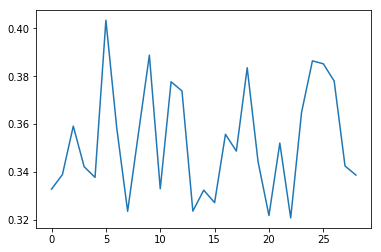


 Current running on: Epoch  9  Training auc: 0.7909222393784098


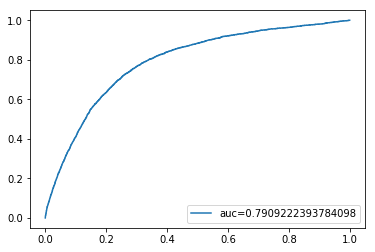


 Current running on: Epoch  9  validation auc: 0.7820633663864068


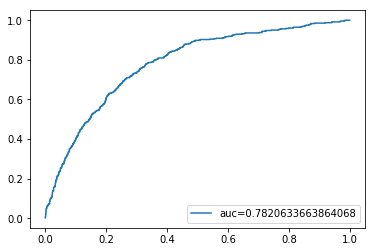


 Current running on: Epoch  9  test auc: 0.804521444031658


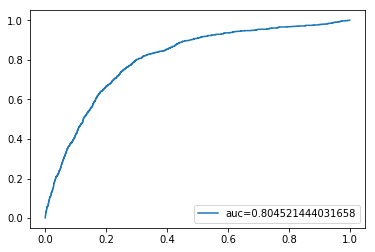

Epoch  9 Summary:  Training_auc : 0.7909222393784098  , Validation_auc :  0.7820633663864068  ,& Test_auc :  0.804521444031658  Avg Loss:  0.3528119231183935 Train Time (0m 44s) Eval Time (0m 17s)

 Current running on: Epoch  10 Training loss:  Average loss 0.3466024389798049
[0.3232968780794781, 0.28082524045414803, 0.3895596411213652, 0.37441284384787915, 0.3546036397926093, 0.3228481892983914, 0.35888568322910097, 0.33768027187042937, 0.35076627672667793, 0.28605140727096295, 0.36899746367966146, 0.34261137652613843, 0.4053576776284317, 0.3693441110625442, 0.3797271451994728, 0.40925961913976655, 0.36298573117696925, 0.3192978591358995, 0.3132139016341123, 0.3378779912535906, 0.35746554178709256, 0.36711574769567734, 0.3473944570774781, 0.3187098668966537, 0.3412717648977459, 0.3396904883076172, 0.30385168258431516, 0.3312641826604968, 0.3571040503796342] 
 train loss plot


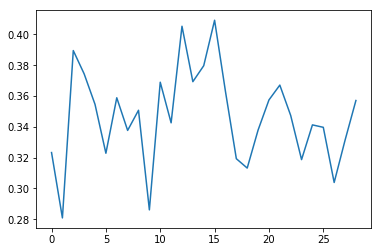


 Current running on: Epoch  10  Training auc: 0.7818725490263028


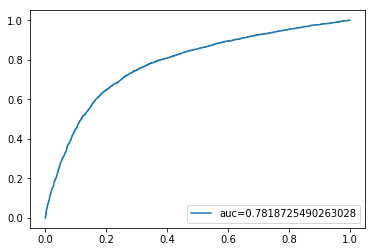


 Current running on: Epoch  10  validation auc: 0.7715155071862705


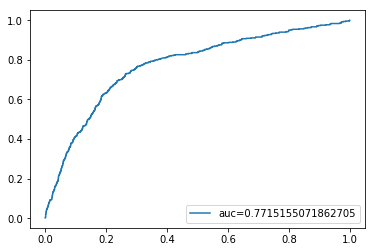


 Current running on: Epoch  10  test auc: 0.7845619071369151


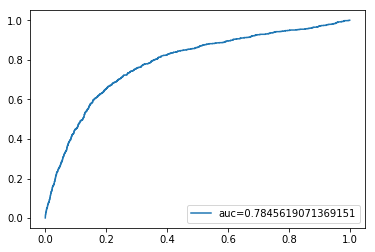

Epoch  10 Summary:  Training_auc : 0.7818725490263028  , Validation_auc :  0.7715155071862705  ,& Test_auc :  0.7845619071369151  Avg Loss:  0.3466024389798049 Train Time (0m 45s) Eval Time (0m 17s)

 Current running on: Epoch  11 Training loss:  Average loss 0.34574376427340153
[0.3009091486022946, 0.3450107151643862, 0.35523169217315037, 0.34740314102536163, 0.3409404728429781, 0.3660564853975502, 0.32915589065675016, 0.308792162865586, 0.3448515014118998, 0.38132378192017835, 0.33313276847605655, 0.3463835826496012, 0.3105957656744255, 0.3288012796066756, 0.383562947835244, 0.3452845292131342, 0.35526572276291424, 0.32637599856043426, 0.36799666208387977, 0.3310131837546806, 0.3730112485880111, 0.34433850839315755, 0.3138202774142574, 0.3317068258889642, 0.3783825209138977, 0.35612131096844596, 0.37288221194869287, 0.3429787525362417, 0.3652400745997982] 
 train loss plot


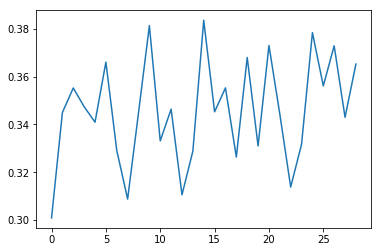


 Current running on: Epoch  11  Training auc: 0.7890097468750539


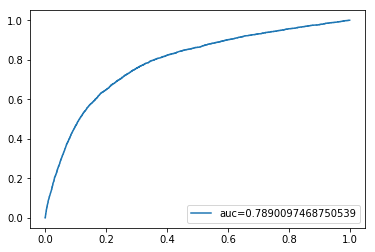


 Current running on: Epoch  11  validation auc: 0.7779458025765987


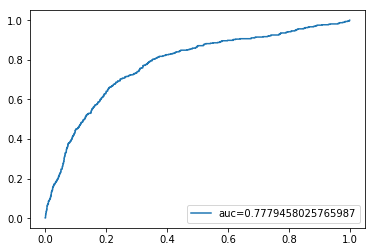


 Current running on: Epoch  11  test auc: 0.7963913621781056


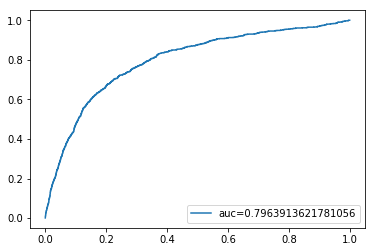

Epoch  11 Summary:  Training_auc : 0.7890097468750539  , Validation_auc :  0.7779458025765987  ,& Test_auc :  0.7963913621781056  Avg Loss:  0.34574376427340153 Train Time (0m 44s) Eval Time (0m 17s)

 Current running on: Epoch  12 Training loss:  Average loss 0.34379060726622407
[0.31978723782102914, 0.314245571371391, 0.35119619704828503, 0.30113050616811404, 0.3639702899467792, 0.3906124230218088, 0.3203242816091492, 0.3562491624303416, 0.3255379247518758, 0.3818660555468406, 0.3126568937525493, 0.3115415994428182, 0.3264163085814291, 0.3416759013344563, 0.3399260095888565, 0.3848446535471089, 0.3820862466955905, 0.34460128365306236, 0.32899473419696734, 0.35996106582197174, 0.29556575332020496, 0.37604762644983997, 0.384759757914167, 0.34143450911240425, 0.3475876370224576, 0.31712427665864856, 0.3667268555535672, 0.35379449018086234, 0.32926235817792415] 
 train loss plot


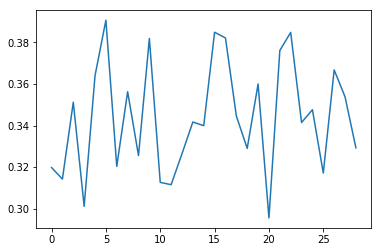


 Current running on: Epoch  12  Training auc: 0.7720763312016942


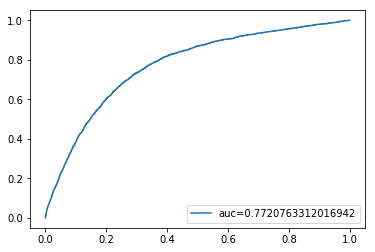


 Current running on: Epoch  12  validation auc: 0.751333952976006


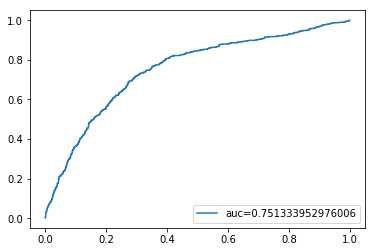


 Current running on: Epoch  12  test auc: 0.7870788515211532


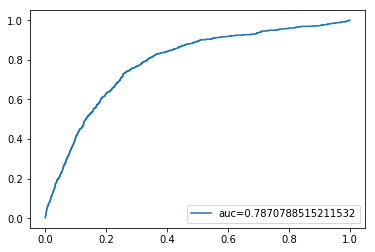

Epoch  12 Summary:  Training_auc : 0.7720763312016942  , Validation_auc :  0.751333952976006  ,& Test_auc :  0.7870788515211532  Avg Loss:  0.34379060726622407 Train Time (0m 49s) Eval Time (0m 17s)

 Current running on: Epoch  13 Training loss:  Average loss 0.34042020733066286
[0.3302255252255118, 0.3353938796860693, 0.33740855040317935, 0.34102641980702403, 0.34051192148188797, 0.32523249562850104, 0.3063217838157989, 0.31935917032389843, 0.3347987608881585, 0.3615927358448048, 0.3528697020842345, 0.3468522906218876, 0.31837131125466994, 0.35009174730982867, 0.3458438770371868, 0.3158747667163532, 0.37250982518021386, 0.35344263889945193, 0.3358375661015332, 0.3503397254802726, 0.39396593629750565, 0.3162394105990902, 0.3518021372053713, 0.3585314974285866, 0.3448445951765949, 0.30977893786966165, 0.3327702878405235, 0.3432052686091365, 0.34714324777228783] 
 train loss plot


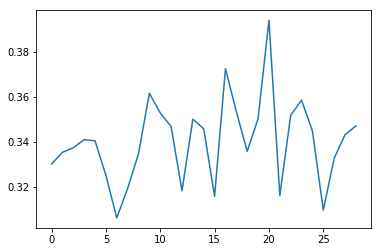


 Current running on: Epoch  13  Training auc: 0.7616321700823594


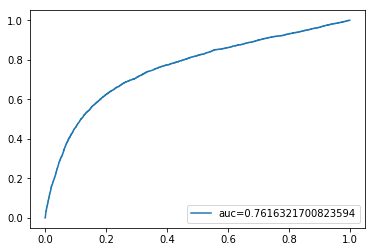


 Current running on: Epoch  13  validation auc: 0.7375668479148805


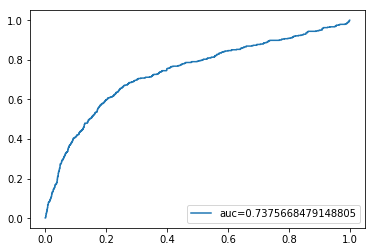


 Current running on: Epoch  13  test auc: 0.7592592768855022


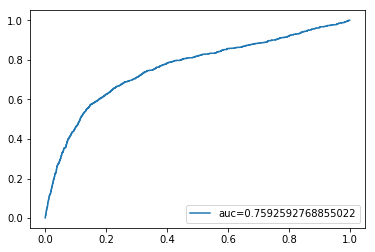

Epoch  13 Summary:  Training_auc : 0.7616321700823594  , Validation_auc :  0.7375668479148805  ,& Test_auc :  0.7592592768855022  Avg Loss:  0.34042020733066286 Train Time (0m 52s) Eval Time (0m 23s)

 Current running on: Epoch  14 Training loss:  Average loss 0.3395999548138914
[0.3327317796842317, 0.341486142569044, 0.357172177380437, 0.38900826412900913, 0.344704553516327, 0.3451456096353904, 0.326493559214437, 0.3235018853323056, 0.30556039572679333, 0.3318125338460785, 0.33188551133958344, 0.37391932203086253, 0.3543850572528736, 0.34433872662972614, 0.33484021944032055, 0.3290007678124457, 0.32662460010604216, 0.32446994674948176, 0.3552226314386844, 0.3465411287621559, 0.3427398593500863, 0.3312634684696271, 0.3306066827748329, 0.3292716244762787, 0.3107752862621137, 0.3770619326862054, 0.32770261440344167, 0.336801962597175, 0.3433304459868597] 
 train loss plot


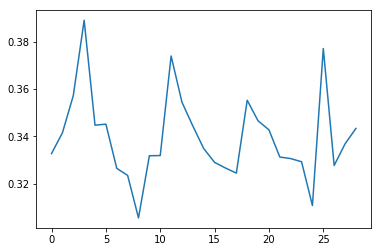


 Current running on: Epoch  14  Training auc: 0.7733939256227058


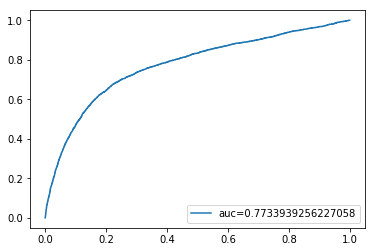


 Current running on: Epoch  14  validation auc: 0.7394623862144258


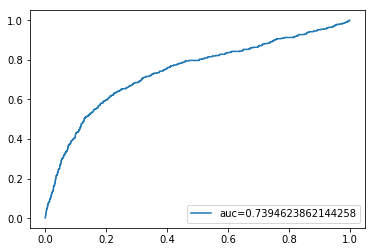


 Current running on: Epoch  14  test auc: 0.7853796540117596


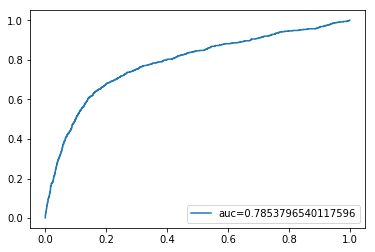

Epoch  14 Summary:  Training_auc : 0.7733939256227058  , Validation_auc :  0.7394623862144258  ,& Test_auc :  0.7853796540117596  Avg Loss:  0.3395999548138914 Train Time (0m 50s) Eval Time (0m 17s)

 Current running on: Epoch  15 Training loss:  Average loss 0.3394489886753615
[0.2845359669816873, 0.35443535497985906, 0.3628466132273561, 0.34930295404286793, 0.31649315090513935, 0.36896268530826365, 0.32486034685571563, 0.38258170969706773, 0.3688154012431078, 0.32285086685769604, 0.33916306103370947, 0.34671704602689796, 0.3466986170701093, 0.35154126513555456, 0.31840616081927053, 0.34525422255969623, 0.3106331710753785, 0.345830948325578, 0.3160861524690505, 0.3709654539799085, 0.32084886506932014, 0.32484318389785577, 0.349535980136935, 0.3495217170579047, 0.34627070967930557, 0.32389284377832883, 0.3305137952570142, 0.3756366084626134, 0.2959758196522889] 
 train loss plot


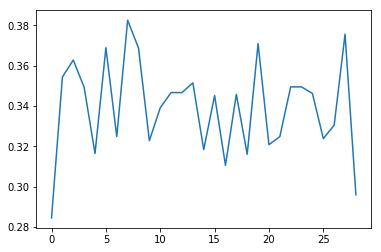


 Current running on: Epoch  15  Training auc: 0.7548834458562614


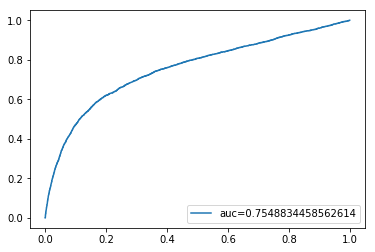


 Current running on: Epoch  15  validation auc: 0.7165476286100061


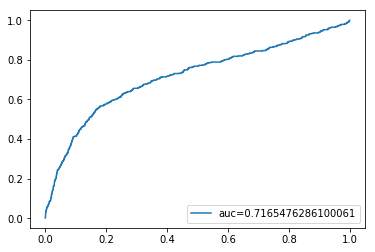


 Current running on: Epoch  15  test auc: 0.7506250718961855


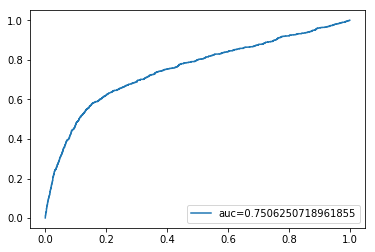

Epoch  15 Summary:  Training_auc : 0.7548834458562614  , Validation_auc :  0.7165476286100061  ,& Test_auc :  0.7506250718961855  Avg Loss:  0.3394489886753615 Train Time (0m 51s) Eval Time (0m 16s)

 Current running on: Epoch  16 Training loss:  Average loss 0.3361696892717056
[0.3285859643142835, 0.3503873880156036, 0.35265059711650154, 0.3406384806464912, 0.32166746527846407, 0.31866344086609844, 0.3270321505891443, 0.3406544396027757, 0.32645116944537583, 0.345928775067372, 0.3344836417048793, 0.3595689647638266, 0.3445253104394506, 0.37170216863687894, 0.31038677937467596, 0.34131759408796936, 0.33105300017882006, 0.3208920536292603, 0.3072448857547799, 0.353371201513886, 0.2903333638923259, 0.3509171403666763, 0.33701949269258696, 0.3481967733722372, 0.34930655203365507, 0.32365530210061116, 0.3564229186743287, 0.3686617049639899, 0.297202269756514] 
 train loss plot


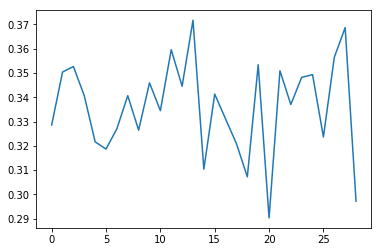


 Current running on: Epoch  16  Training auc: 0.7829004193852761


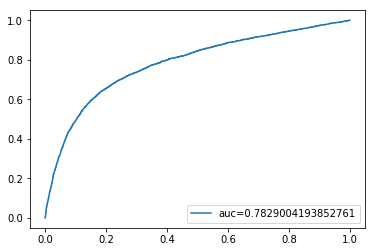


 Current running on: Epoch  16  validation auc: 0.7504919165045159


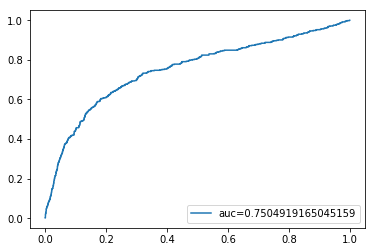


 Current running on: Epoch  16  test auc: 0.7976487805727056


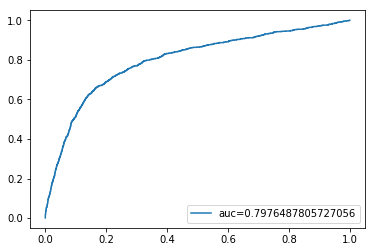

Epoch  16 Summary:  Training_auc : 0.7829004193852761  , Validation_auc :  0.7504919165045159  ,& Test_auc :  0.7976487805727056  Avg Loss:  0.3361696892717056 Train Time (0m 49s) Eval Time (0m 16s)

 Current running on: Epoch  17 Training loss:  Average loss 0.33583693070875065
[0.3374682153976177, 0.3098453165904625, 0.3385653298601117, 0.3604096508569849, 0.3264535960874882, 0.3549100191982343, 0.3256199419859922, 0.32594521570684676, 0.33645207882472666, 0.342025088086255, 0.33188951380496895, 0.351921865818802, 0.35322379987917957, 0.32406449351972, 0.30430741608476797, 0.34683498611141, 0.28513172200669845, 0.3342577982724579, 0.3499923420413779, 0.332464636579497, 0.34876884277382486, 0.34111022285124, 0.3371706833082353, 0.34722583773524, 0.35827007190259064, 0.32098492101477133, 0.33951482247092735, 0.3567858749948573, 0.3176566867884794] 
 train loss plot


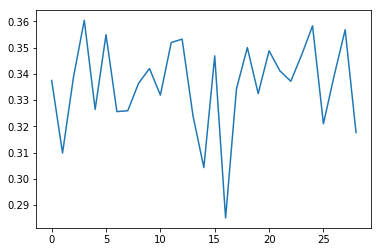


 Current running on: Epoch  17  Training auc: 0.7838364595882867


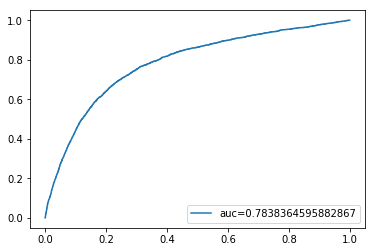


 Current running on: Epoch  17  validation auc: 0.7607015404185703


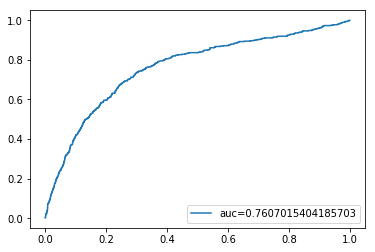


 Current running on: Epoch  17  test auc: 0.7857911109527771


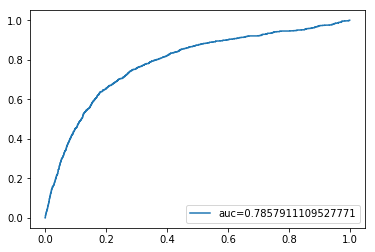

Epoch  17 Summary:  Training_auc : 0.7838364595882867  , Validation_auc :  0.7607015404185703  ,& Test_auc :  0.7857911109527771  Avg Loss:  0.33583693070875065 Train Time (0m 51s) Eval Time (0m 16s)

 Current running on: Epoch  18 Training loss:  Average loss 0.33573285792401986
[0.3277853578616969, 0.3126696410514578, 0.32312283723669727, 0.35615015349093393, 0.34354710582904135, 0.31011001385505005, 0.32768103094499396, 0.34179924171547105, 0.3199526187500708, 0.35228186255440586, 0.3438939822355735, 0.35650160046861856, 0.33796778120985255, 0.29789955812374286, 0.3260942515150202, 0.34288955501774715, 0.3564763771161588, 0.31154329840372974, 0.35968307312050546, 0.31019658192429594, 0.34706285010009696, 0.31296823068694724, 0.34588083190036834, 0.32862647400115386, 0.3514020603509707, 0.3340812907361378, 0.38196914661600384, 0.31761736985345973, 0.3583987031263705] 
 train loss plot


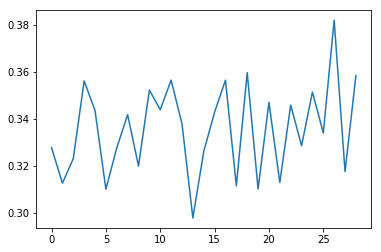


 Current running on: Epoch  18  Training auc: 0.7933853820518602


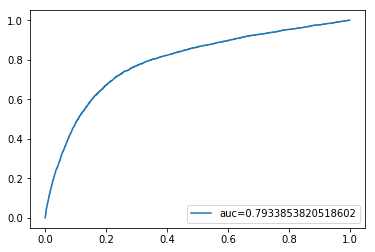


 Current running on: Epoch  18  validation auc: 0.7715745207741491


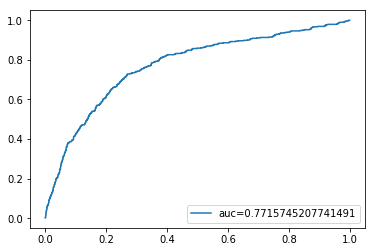


 Current running on: Epoch  18  test auc: 0.7960353825774502


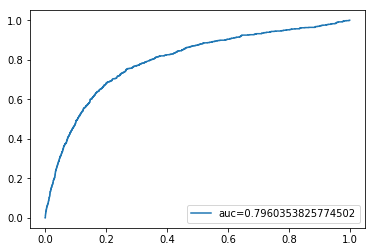

Epoch  18 Summary:  Training_auc : 0.7933853820518602  , Validation_auc :  0.7715745207741491  ,& Test_auc :  0.7960353825774502  Avg Loss:  0.33573285792401986 Train Time (0m 51s) Eval Time (0m 16s)

 Current running on: Epoch  19 Training loss:  Average loss 0.333821000051086
[0.34670037191406483, 0.3211566162389572, 0.31970883279285967, 0.3115789522806117, 0.35108147335948364, 0.32613713264645683, 0.33818470769219855, 0.3710926861925095, 0.3052900391102203, 0.3525058700256741, 0.33086107100744655, 0.36513154492993044, 0.30516867382886903, 0.3082438185500805, 0.30738784614962444, 0.31105536480067214, 0.3928911199572549, 0.3526699830033319, 0.3431932720443438, 0.34227544854045894, 0.3504950287948486, 0.3163933309375716, 0.3211276078277588, 0.339935177443539, 0.3389856476167624, 0.3103095640799641, 0.3543590978220527, 0.29550909311575196, 0.3513796287781952] 
 train loss plot


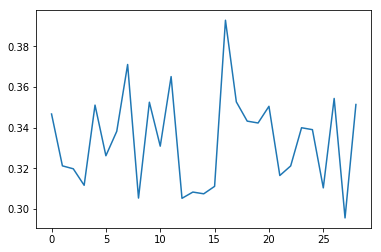


 Current running on: Epoch  19  Training auc: 0.7869567002969294


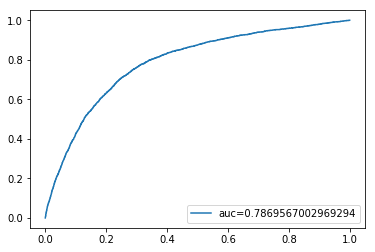


 Current running on: Epoch  19  validation auc: 0.766144177845097


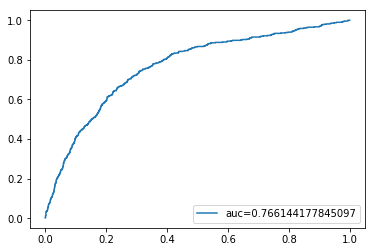


 Current running on: Epoch  19  test auc: 0.7941748520672243


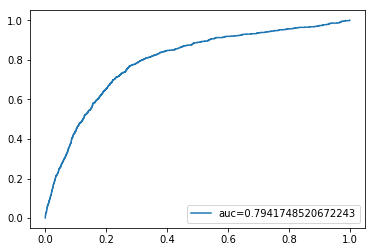

Epoch  19 Summary:  Training_auc : 0.7869567002969294  , Validation_auc :  0.766144177845097  ,& Test_auc :  0.7941748520672243  Avg Loss:  0.333821000051086 Train Time (0m 49s) Eval Time (0m 17s)

 Current running on: Epoch  20 Training loss:  Average loss 0.33218862334550114
[0.3284209842768887, 0.31367976134567654, 0.3010848577961165, 0.34070380069528616, 0.3246892316945369, 0.3542643822490243, 0.33426081565111965, 0.3505678292735083, 0.33821365360193706, 0.3355733659387487, 0.33535732275896263, 0.3177201389597085, 0.344635794085317, 0.3575159160340959, 0.3605922858416952, 0.31770482423811247, 0.33705012951350183, 0.30791135496497735, 0.34578053668391256, 0.3321963398496922, 0.3204568389343186, 0.31314688468036866, 0.33398981856649934, 0.33822670069315475, 0.3329505656150823, 0.35078827229800663, 0.3077362768689587, 0.3340419999505866, 0.3242093939597398] 
 train loss plot


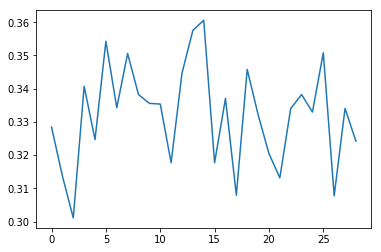


 Current running on: Epoch  20  Training auc: 0.7884861394668587


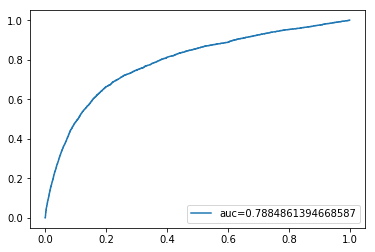


 Current running on: Epoch  20  validation auc: 0.7653158019263564


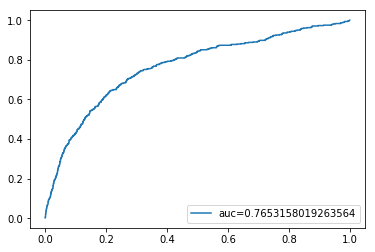


 Current running on: Epoch  20  test auc: 0.7983207634552267


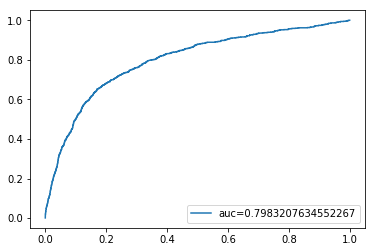

Epoch  20 Summary:  Training_auc : 0.7884861394668587  , Validation_auc :  0.7653158019263564  ,& Test_auc :  0.7983207634552267  Avg Loss:  0.33218862334550114 Train Time (0m 50s) Eval Time (0m 16s)

 Current running on: Epoch  21 Training loss:  Average loss 0.33164522811766045
[0.31835546999842335, 0.3195118916654958, 0.29466534055064836, 0.33977577799692527, 0.3583794317094216, 0.2953866877981491, 0.32072731350947653, 0.32466338168715536, 0.3330748448369396, 0.33871935780159446, 0.354325942617892, 0.3292392633821892, 0.31296516663078455, 0.3392827373071274, 0.3131645040403963, 0.34965288509082165, 0.32505534115910106, 0.3385714893079187, 0.3456740892141679, 0.31577488453520597, 0.35678964886011816, 0.36210427935099876, 0.31850759788101346, 0.31941844532687436, 0.3608183204723591, 0.3364999665964974, 0.35409747359185345, 0.3264276398534421, 0.31608244263916274] 
 train loss plot


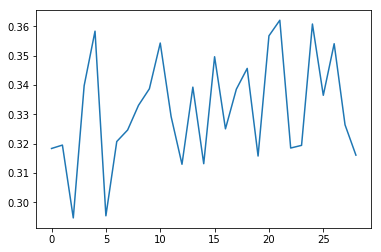


 Current running on: Epoch  21  Training auc: 0.7761813787115964


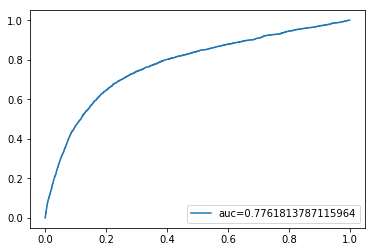


 Current running on: Epoch  21  validation auc: 0.7455626426503221


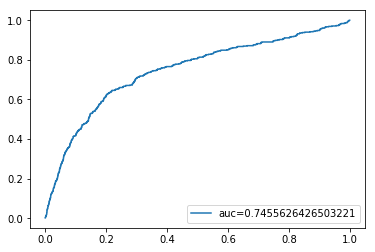


 Current running on: Epoch  21  test auc: 0.7746464203382105


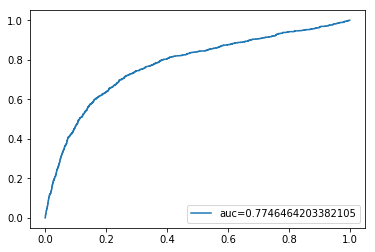

Epoch  21 Summary:  Training_auc : 0.7761813787115964  , Validation_auc :  0.7455626426503221  ,& Test_auc :  0.7746464203382105  Avg Loss:  0.33164522811766045 Train Time (0m 50s) Eval Time (0m 16s)

 Current running on: Epoch  22 Training loss:  Average loss 0.33133923763286915
[0.3038377726171584, 0.3203369863229145, 0.329466844283063, 0.30813176402791215, 0.31091121208289907, 0.3361716400052592, 0.31339954217080884, 0.3815141702756664, 0.36093127315807944, 0.3374415864904586, 0.28885432074314826, 0.32349475144784473, 0.33742481968535654, 0.314433152186328, 0.3184725618151351, 0.3366481446802636, 0.3607764206269874, 0.3550825981349735, 0.3351673013968575, 0.3051954971644451, 0.3442574463320213, 0.37224161785193427, 0.31120321151296865, 0.31561216631358546, 0.34668034906320055, 0.3627984209275419, 0.3179733549159646, 0.3307303546095903, 0.32964861051083943] 
 train loss plot


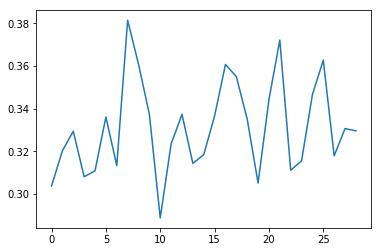


 Current running on: Epoch  22  Training auc: 0.7645772436881798


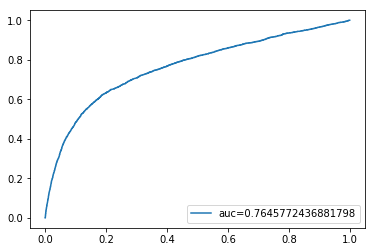


 Current running on: Epoch  22  validation auc: 0.7236210628237892


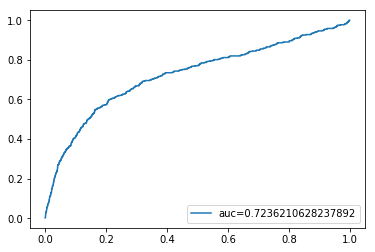


 Current running on: Epoch  22  test auc: 0.7684075311033436


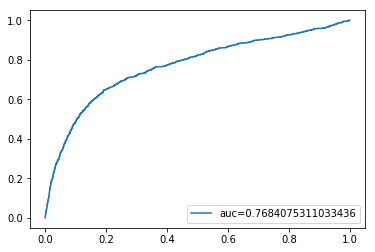

Epoch  22 Summary:  Training_auc : 0.7645772436881798  , Validation_auc :  0.7236210628237892  ,& Test_auc :  0.7684075311033436  Avg Loss:  0.33133923763286915 Train Time (0m 49s) Eval Time (0m 16s)

 Current running on: Epoch  23 Training loss:  Average loss 0.3283096911380924
[0.31637005470074336, 0.3217847176012001, 0.32369591554638305, 0.3249059951275267, 0.29593610650406615, 0.3251080098474176, 0.33882005261599263, 0.3256017563507703, 0.32199819828625187, 0.3171253528286179, 0.3273376604868131, 0.32801347893532684, 0.3008932209096274, 0.35359472854896373, 0.3233053499771122, 0.3332434100186019, 0.36262961046077546, 0.3729335375365117, 0.36230521751504646, 0.3625982233486502, 0.31956726348100073, 0.33630691771009513, 0.2840065331781116, 0.34224334198954104, 0.32098918263077, 0.32167960262770157, 0.31927245621794736, 0.327685645663479, 0.311029502359635] 
 train loss plot


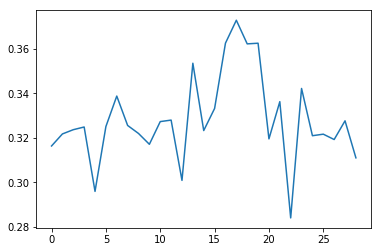


 Current running on: Epoch  23  Training auc: 0.7876864494135075


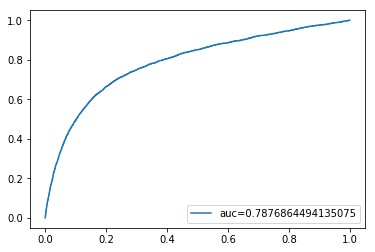


 Current running on: Epoch  23  validation auc: 0.7606701211472461


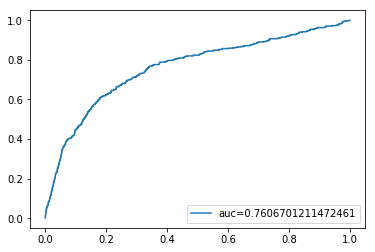


 Current running on: Epoch  23  test auc: 0.7957335205784221


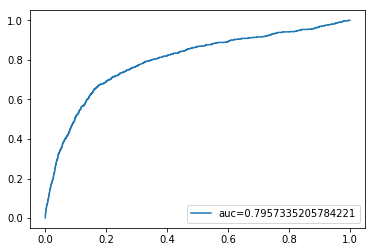

Epoch  23 Summary:  Training_auc : 0.7876864494135075  , Validation_auc :  0.7606701211472461  ,& Test_auc :  0.7957335205784221  Avg Loss:  0.3283096911380924 Train Time (0m 50s) Eval Time (0m 17s)

 Current running on: Epoch  24 Training loss:  Average loss 0.32822542547230116
[0.3210239253008144, 0.3441816814375034, 0.3129275696430958, 0.37531188707764884, 0.3436415759439426, 0.2928932874223101, 0.34375028529777046, 0.33044440125594704, 0.29527631938159205, 0.335536341872732, 0.3543243168428576, 0.34546324105009435, 0.32092526923140396, 0.3580574363624873, 0.3644042956081066, 0.3163593043189394, 0.3278646071420953, 0.3411695006872335, 0.2946589808258113, 0.3227929241748736, 0.3364396672526345, 0.31088703354631797, 0.31655609688508046, 0.3372192535340364, 0.31281174432038644, 0.3002862156130213, 0.31737368376495756, 0.32671830242064515, 0.31923819048239466] 
 train loss plot


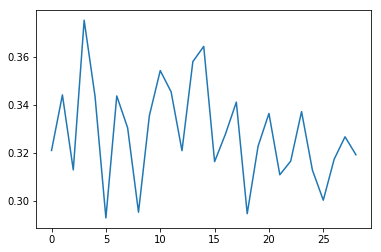


 Current running on: Epoch  24  Training auc: 0.7989318850605049


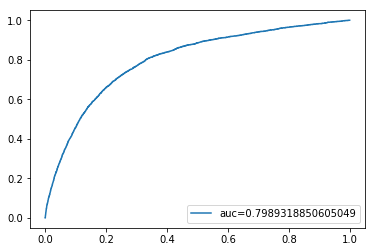


 Current running on: Epoch  24  validation auc: 0.7833280603599719


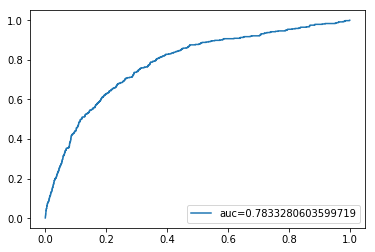


 Current running on: Epoch  24  test auc: 0.8081429041898173


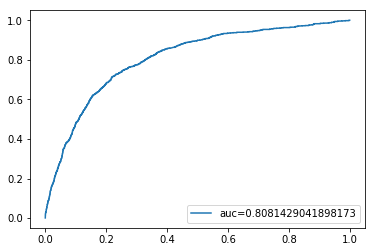

Epoch  24 Summary:  Training_auc : 0.7989318850605049  , Validation_auc :  0.7833280603599719  ,& Test_auc :  0.8081429041898173  Avg Loss:  0.32822542547230116 Train Time (0m 51s) Eval Time (0m 17s)


In [10]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    TVT.auc_plot(y_real, y_hat)
    valid_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    TVT.auc_plot(y_real, y_hat)
    test_auc, y_real, y_hat = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)

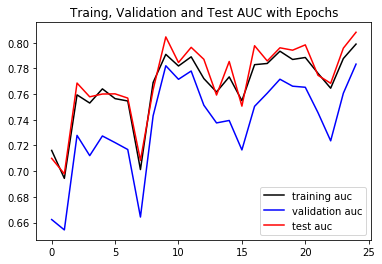

In [11]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label = 'test auc')
plt.title('Traing, Validation and Test AUC with Epochs' )
#plt.xtickes(np.arange(epoches))
plt.legend(loc= 'lower right')
plt.show()

In [12]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg,valid_auc_fg, test_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim128_BOted')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')